In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Import the two dataframes from the Zendesk platform of the company and merge them to creat a complete dataframe.

In [2]:
# import the dataframes
df1 = pd.read_csv('/content/Ticket_history.csv')
#df1.copy = df1.drop(columns='due_at')
df2 = pd.read_csv('/content/ticket_full.csv')

<ipython-input-2-0c6c658779b7>:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/Ticket_history.csv')
<ipython-input-2-0c6c658779b7>:4: DtypeWarning: Columns (33,66,68,69,70,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/ticket_full.csv')


### Extract relevant fields from the df2 which will be merged with the df1.

In [5]:
# select columns to show
selected_columns = ['id','recipient', 'description', 'subject']
df2_1 = df2[selected_columns]
df2_1.shape

(15541, 4)

In [6]:
# merge ticket and ticket history dataframes
merged = df1.merge(df2_1, on='id', how='left')
merged.shape

(411678, 30)

## Determine the number of users communicated the assignee for one ticket.

In [10]:
# Determine the number of users communicated the assignee for each ticket.
users_per_ticket = merged[merged['user_id'] != -1].groupby('id')['user_id'].nunique().reset_index().sort_values('id', ascending=True)
users_per_ticket.columns = ['id', 'num_users']
users_per_ticket.sort_values(by='num_users', ascending=False).head()


,id,num_users
3553,3745,13
5695,5928,10
5978,6232,10
275,310,9
11170,11540,9


### Calculate the average character length of the subject used to create the ticket.

In [11]:
# determine the average ength of the subject pe id.
avg_sub_len = merged.groupby('id')['len_subj'].mean().reset_index().sort_values('id', ascending=True)
print(avg_sub_len.head())
avg_sub_len.shape

   id  len_subj
0   8      16.0
1  13      21.0
2  14      11.0
3  15      12.0
4  16       6.0


(15430, 2)

### Determine the average response time per ticket id.

In [12]:
# Determine the mean response time per user_id.
avg_resp_time = merged.groupby('id')['resposne_days'].mean().reset_index().sort_values('id', ascending=True)
print(avg_resp_time.head())
avg_resp_time.shape

   id  resposne_days
0   8            0.0
1  13           11.0
2  14            2.0
3  15            0.0
4  16            9.0


(15430, 2)

### Determine the length of the description used to explain the issue.

In [13]:
# determien the average lenght of the description of the issue.
avg_desc_len = merged.groupby('id')['len_descr'].mean().reset_index().sort_values('id', ascending=True)
avg_desc_len.head()
avg_desc_len.shape

(15430, 2)

### How many employee (assignee) handeled each ticket? For that count the number of distinct assignee per ticket id.

In [13]:
# Detetmine the number of employees assigned to handle each case or ticket.
num_assignee_per_ticket = merged[merged['assignee_id'] != -1].groupby('id')['assignee_id'].nunique().reset_index().sort_values('id', ascending=True)
num_assignee_per_ticket.columns = ['id', 'num_assignee']
print(num_assignee_per_ticket.head())
num_assignee_per_ticket.num_assignee.value_counts() # the result show that only one employee handeled each ticket.

   id  num_assignee
0   8             1
1  13             1
2  14             1
3  15             1
4  16             1


,count
num_assignee,
1,15115
0,315


### Merge the calculated metrix above into df2.

In [14]:
# Merge all the calculated metrics
df5 = pd.merge(df2, users_per_ticket, on='id', how='left')
df6 = pd.merge(df5, avg_sub_len, on='id', how='left')
df7 = pd.merge(df6, avg_resp_time, on='id', how='left')
df8 = pd.merge(df7, avg_desc_len, on='id', how='left')
df8 = df8.drop(columns='url')
df8.head(2)


,id,assignee_id,brand_id,forum_topic_id,organization_id,requester_id,submitter_id,group_id,custom_status_id,external_id,...,system_ccs,system_raw_email,via_source_from_post_id,via_source_from_post_name,custom_post_path,custom_slack_url,num_users,len_subj,resposne_days,len_descr
0,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,"[{""name"":""Rotem Ashkenazi"",""address"":""rotem.as...",NaN,NaN,NaN,NaN,NaN,2.0,34.0,0.0,255.0
1,6724,2.592583e+08,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,"[{""name"":""Yotan Halfon"",""address"":""yotan.halfo...",NaN,NaN,NaN,NaN,NaN,2.0,43.0,0.0,238.0


### Does communication of the same issue by different people delays the resolution?

#### **a ticket is communicated by a maximum of 13 different users and a minimum by 1 user.**

In [22]:
# Determine if the response days vary with the users communication pattern.
resp_per_user_number = df8.groupby('num_users')['resposne_days'].agg(['count', 'mean']).reset_index()
resp_per_user = resp_per_user_number
resp_per_user = resp_per_user.query("num_users >= 1")
resp_per_user
# the time needed to resolve an issue increases linearly with an increase in the number of contacting users

,num_users,count,mean
1,1.0,414,22.961353
2,2.0,9458,30.860330
3,3.0,4107,42.580472
4,4.0,995,66.846231
5,5.0,247,75.987854
6,6.0,64,104.140625
7,7.0,22,132.681818
8,8.0,9,90.222222
9,9.0,3,68.333333
10,10.0,2,49.500000


In [79]:
# save the resp_per_user as csv.
resp_per_user.to_csv('resp_per_user.csv', index=False)

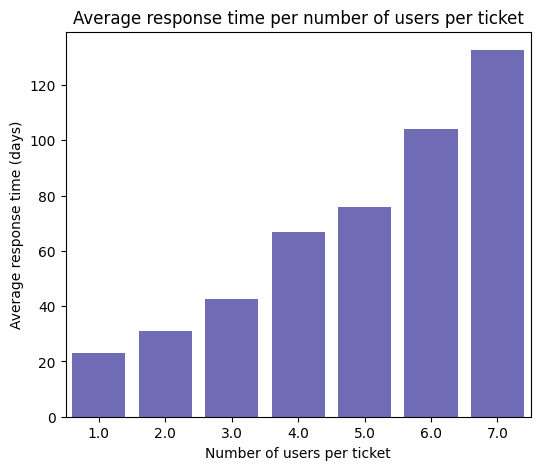

In [23]:
# plot the average resposne time per number of tickets.
plt.figure(figsize=(6,5))
sns.barplot(data=resp_per_user.head(7), x='num_users', y='mean', color='#6460C1')
plt.ylabel('Average response time (days)')
plt.xlabel('Number of users per ticket')
plt.title('Average response time per number of users per ticket')
plt.show()

### Calculate the number of tickets associated with the num_users category.

#### The largest proportion of the tickets is communicate by two or three users.

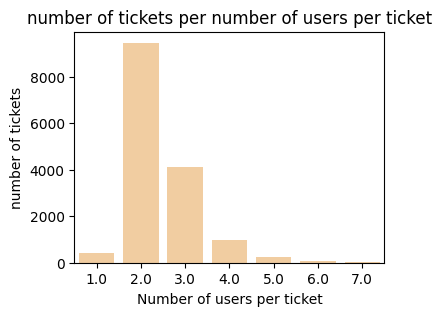

In [30]:
plt.figure(figsize=(4,3))
sns.barplot(data=resp_per_user.head(7), x='num_users', y='count', color='#FFCE93')
plt.ylabel('number of tickets')
plt.xlabel('Number of users per ticket')
plt.title('number of tickets per number of users per ticket')
plt.show()

### Does the priority settings affect the average resolution time of the issue?

In [29]:
# calculate the average resolution time by ticket priority category.
resp_priority = df8.groupby('priority')['resposne_days'].agg(['count', 'mean']).reset_index()
resp_priority #

,priority,count,mean
0,high,1145,38.841921
1,low,678,102.277286
2,normal,11095,36.681027
3,urgent,780,32.847436


In [80]:
# save the resp_priority df as csv.
resp_priority.to_csv('resp_priority.csv', index=False)

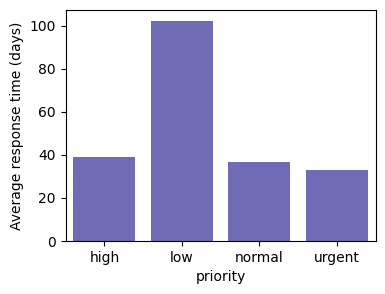

In [33]:
# plot the mean response days and message count per priority type
plt.figure(figsize=(4,3))
sns.barplot(data=resp_priority, x='priority', y='mean', color='#6460C1')
plt.ylabel('Average response time (days)')
plt.xlabel
plt.show()

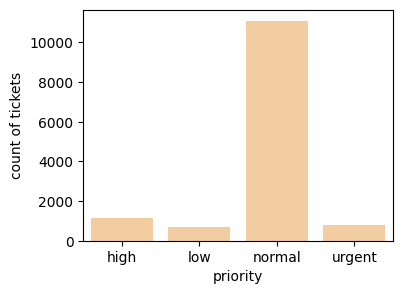

In [37]:
# plot the count of tickets per priority category
plt.figure(figsize=(4,3))
sns.barplot(data=resp_priority, x='priority', y='count', color='#FFCE93')
plt.ylabel('count of tickets')
plt.xlabel
plt.show()

### What are the main topics of the tickets? Determine the common words in the description column.

In [26]:
from collections import Counter
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# Load dataset
dfn = pd.read_csv("/content/masked_ticket.csv")

# Check if column exists
if 'masked_description' in dfn.columns:
    descriptions = dfn['masked_description'].dropna().astype(str)

    # Define stopwords & punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    # Tokenize words & clean
    words = [word.lower() for desc in descriptions for word in desc.split()
             if word.lower() not in stop_words and word not in punctuation]

    # Count word frequency
    word_counts = Counter(words)

    # Get top 10 most common words
    most_common_words = word_counts.most_common(25)
    most_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    # print(most_common_words)
else:
    print("Column 'masked_description' not found.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Non tokenization common words in the description
please 13157
licence 7799
text 7710
regards 6150
server 5732
symphony 5610, new, information

In [39]:
# Check if column exists
if 'masked_subject' in dfn.columns:
    descriptions = dfn['masked_subject'].dropna().astype(str)

    # Define stopwords & punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    # Tokenize words & clean
    words = [word.lower() for desc in descriptions for word in desc.split()
             if word.lower() not in stop_words and word not in punctuation]

    # Count word frequency
    word_counts = Counter(words)

    # Get top 10 most common words
    most_common_words = word_counts.most_common(20)
    most_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    # print(most_common_words)
else:
    print("Column 'masked_description' not found.")


Common subject words
license 3027, re: 1023, fw: 785, server 741, symphony 731,  question, renewal

In [40]:
# assign columns for the presence of the following common words.
dfn['please'] = dfn['masked_description'].apply(lambda x: 1 if 'please' in str(x).lower() else 0)
dfn['licence'] = dfn['masked_description'].apply(lambda x: 1 if 'license' in str(x).lower() else 0)
dfn['text'] = dfn['masked_description'].apply(lambda x: 1 if 'text' in str(x).lower() else 0)
dfn['regards'] = dfn['masked_description'].apply(lambda x: 1 if 'regards' in str(x).lower() else 0)
dfn = dfn.sort_values('id', ascending=True)
dfn['re:'] = dfn['masked_subject'].apply(lambda x: 1 if 're:' in str(x).lower() else 0)
dfn['fw:'] = dfn['masked_subject'].apply(lambda x: 1 if 'fw:' in str(x).lower() else 0)
dfn['server'] = dfn['masked_subject'].apply(lambda x: 1 if 'server' in str(x).lower() else 0)
dfn['question'] = dfn['masked_subject'].apply(lambda x: 1 if 'question' in str(x).lower() else 0)
dfn['renewal'] = dfn['masked_subject'].apply(lambda x: 1 if 'renewal' in str(x).lower() else 0)
dfn['symphony'] = dfn['masked_subject'].apply(lambda x: 1 if 'symphony' in str(x).lower() else 0)
dfn['new'] = dfn['masked_description'].apply(lambda x: 1 if 'new' in str(x).lower() else 0)
dfn['information'] = dfn['masked_description'].apply(lambda x: 1 if 'information' in str(x).lower() else 0)

In [41]:
selected_columns = ['id', 'please', 'licence', 'text', 're:','fw:','regards', 'server', 'symphony',
                     'question', 'renewal', 'new', 'information']
dfn1 = dfn[selected_columns]

In [42]:
# filter out tickets which have been resolved within a year.
merged1 = df8.merge(dfn1, on='id', how='left')
merged2 = merged1.query("resposne_days <= 365")
merged2.shape

(15376, 91)

### Request for information is one of the most frequent topic in the dataframe. Does the tickets requesting for information has different resolution time that other types?


In [45]:
# Determine the average response time for tickets requesting only information.
resp_please = merged1.groupby('information')['resposne_days'].agg(['count', 'mean']).reset_index()
resp_please # There is not really big diffence.

,information,count,mean
0,0.0,12243,36.756269
1,1.0,3187,38.417007


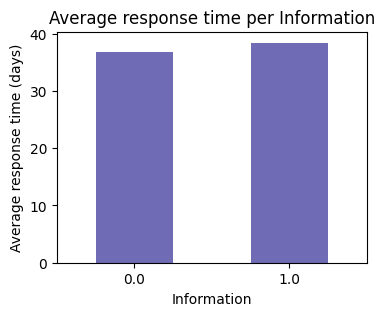

In [44]:
# plot the average resolution time for information seeking tickets vs non_information seeking tickets.
plt.figure(figsize=(4,3))
sns.barplot(data=resp_please, x='information', y='mean', color='#6460C1', width=0.5)
plt.ylabel('Average response time (days)')
plt.xlabel('Information')
plt.title('Average response time per Information')
plt.show()

### How does the performace of the customer support department be described based on resolution time.

In [49]:
resp_perc_33 = merged1['resposne_days'].quantile(0.33)
resp_perc_67 = merged1['resposne_days'].quantile(0.67)
def response_categ(row):
  response = row['resposne_days']
  if response <= resp_perc_33:
    return 'Quick'
  elif response > resp_perc_33 and response <= resp_perc_67:
    return 'Normal'
  else:
    return 'Slow'
merged1.loc[:, 'response_categ'] = merged1.apply(response_categ, axis=1)
merged1.head()

,id,assignee_id,brand_id,forum_topic_id,organization_id,requester_id,submitter_id,group_id,custom_status_id,external_id,...,re:,fw:,regards,server,symphony,question,renewal,new,information,response_categ
0,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick
1,6724,2.592583e+08,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick
2,3763,3.532298e+08,2129676.0,NaN,23073316.0,397914276,259258347,20349457.0,4420939,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Quick
3,827,2.592583e+08,NaN,NaN,NaN,458485706,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick
4,668,2.592583e+08,NaN,NaN,NaN,426824631,259258347,20349457.0,4420939,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick


In [50]:
# determine the number of tickets per response category.
ticket_response = merged1.groupby('response_categ')['resposne_days'].agg(['count', 'mean']).reset_index()
ticket_response

,response_categ,count,mean
0,Normal,5009,33.896187
1,Quick,6261,21.554704
2,Slow,4160,64.351442


### How does the length of the description affect the ticket resolution time?

In [51]:
# exclude an outlier of description length
len_descr_cleaned = merged1.query("len_descr < 3000")
len_descr_cleaned.shape

(14549, 92)

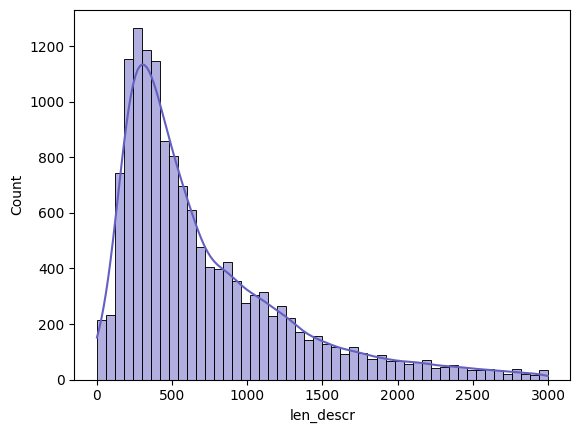

In [52]:
# plot the distribution of the description length.
sns.histplot(data=len_descr_cleaned, x='len_descr', bins=50, kde=True, color='#6460C1')
plt.show()

#### Categorize the description lengths based on the distribution.

In [54]:
# categorize the description lengths based on quantile.
disclen_perc_33 = len_descr_cleaned['len_descr'].quantile(0.33)
disclen_perc_67 = len_descr_cleaned['len_descr'].quantile(0.67)
def discleng_categ(row):
  discr_length = row['len_descr']
  if discr_length <= disclen_perc_33:
    return 'Short'
  elif discr_length > disclen_perc_33 and discr_length <= disclen_perc_67:
    return 'Normal'
  elif discr_length > disclen_perc_67:
    return 'Long'
len_descr_cleaned.loc[:, 'discr_length'] = len_descr_cleaned.apply(discleng_categ, axis=1)
len_descr_cleaned.head()

,id,assignee_id,brand_id,forum_topic_id,organization_id,requester_id,submitter_id,group_id,custom_status_id,external_id,...,fw:,regards,server,symphony,question,renewal,new,information,response_categ,discr_length
0,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short
1,6724,2.592583e+08,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short
2,3763,3.532298e+08,2129676.0,NaN,23073316.0,397914276,259258347,20349457.0,4420939,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Quick,Long
3,827,2.592583e+08,NaN,NaN,NaN,458485706,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Long
4,668,2.592583e+08,NaN,NaN,NaN,426824631,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short


In [57]:
# determine the number of tickets per description category and the mean response time.
resp_disclen = len_descr_cleaned.groupby('discr_length')['resposne_days'].agg(['count', 'mean']).reset_index()
resp_disclen

,discr_length,count,mean
0,Long,4796,40.003545
1,Normal,4952,37.434774
2,Short,4801,33.653197


In [81]:
# save the resp_disclen df as csv.
resp_disclen.to_csv('resp_disclen.csv', index=False)

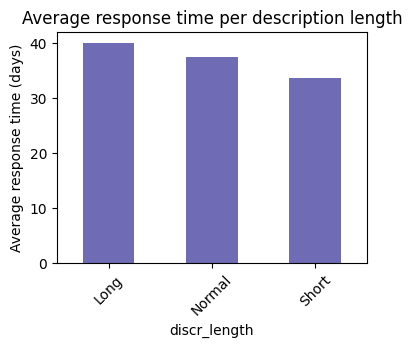

In [58]:
plt.figure(figsize=(4,3))
sns.barplot(data=resp_disclen, x='discr_length', y='mean', color='#6460C1', width=0.5)
plt.ylabel('Average response time (days)')
plt.title('Average response time per description length')
plt.xticks(rotation=45)
plt.show()

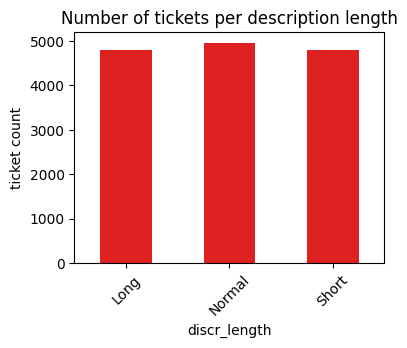

In [59]:
plt.figure(figsize=(4,3))
sns.barplot(data=resp_disclen, x='discr_length', y='count', color='red', width=0.5)
plt.ylabel('ticket count')
plt.title('Number of tickets per description length')
plt.xticks(rotation=45)
plt.show()

### How does the spelling errors in the description affect the message readability and resolution time?

In [60]:
!pip install pyspellchecker
from spellchecker import SpellChecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.7 MB/s eta 0:00:00


### Count the number of errors per description

In [61]:
spell = SpellChecker()

# Function to count spelling errors
def count_misspelled_words(text):
    words = text.split()
    misspelled = spell.unknown(words)  # Get misspelled words
    return len(misspelled)

merged['spelling_errors'] = merged['description'].apply(count_misspelled_words)

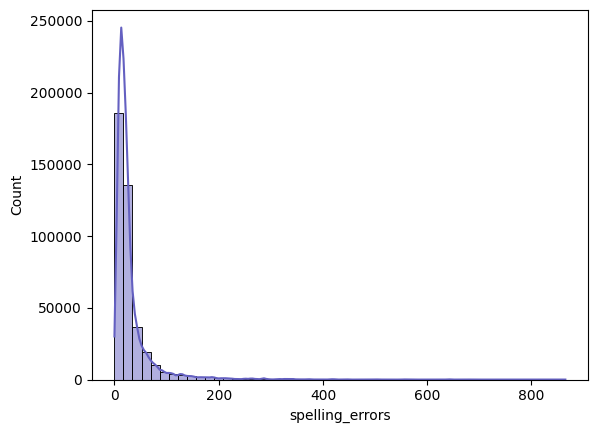

In [63]:
# plot the spellings errors per
sns.histplot(data=merged, x='spelling_errors', bins=50, kde=True, color='#6460C1')
plt.show()

In [62]:
# Determine the number of spelling errors per desciption.
select_cols = ['id', 'spelling_errors']
dfn2 = merged[select_cols].sort_values('spelling_errors', ascending=False)
dfn2.head()

,id,spelling_errors
126731,5177,865
126733,5177,865
126734,5177,865
126735,5177,865
126730,5177,865


In [64]:
df9 = merged1.merge(dfn2, on='id', how='left')
df9.head()

,id,assignee_id,brand_id,forum_topic_id,organization_id,requester_id,submitter_id,group_id,custom_status_id,external_id,...,regards,server,symphony,question,renewal,new,information,response_categ,discr_length,spelling_errors
0,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0
1,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0
2,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0
3,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0
4,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0


In [71]:
# categorize the specilling errors per description.
error_perc_33 = df9['spelling_errors'].quantile(0.33)
error_perc_67 = df9['spelling_errors'].quantile(0.67)
def error_categ(row):
  error_catag = row['spelling_errors']
  if error_catag <= error_perc_33:
    return 'low'
  elif error_catag > error_perc_33 and error_catag <= error_perc_67:
    return 'medium'
  else:
    return 'high'
df9.loc[:, 'error_categ'] = df9.apply(error_categ, axis=1)
df9.head()

,id,assignee_id,brand_id,forum_topic_id,organization_id,requester_id,submitter_id,group_id,custom_status_id,external_id,...,symphony,question,renewal,new,information,response_categ,discr_length,spelling_errors,error_categ,error_rate
0,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529
1,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529
2,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529
3,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529
4,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529


In [72]:
# Determine the number of tickets per error category.
error_categ_resp = df9.groupby('error_categ')['resposne_days'].agg(['count', 'mean']).reset_index()
error_categ_resp

,error_categ,count,mean
0,high,131078,51.171867
1,low,142352,41.314312
2,medium,138248,47.241559


In [82]:
# save the error_categ_resp as csv.
error_categ_resp.to_csv('error_categ_resp.csv', index=False)

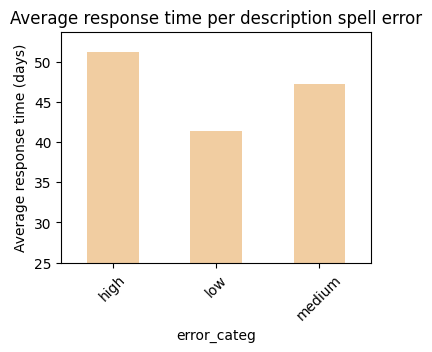

In [67]:
plt.figure(figsize=(4,3))
sns.barplot(data=error_categ_resp, x='error_categ', y='mean', color='#FFCE93', width=0.5)
plt.ylabel('Average response time (days)')
plt.title('Average response time per description spell error')
plt.xticks(rotation=45)
plt.ylim(25, )
plt.show()

### The number of errors varies depending on the length of the description. How is the error rate contribtes to the resolution delay?

In [75]:
# calculate the error are per lenght of the description.
df9['error_rate'] = df9['spelling_errors'] / df9['len_descr']

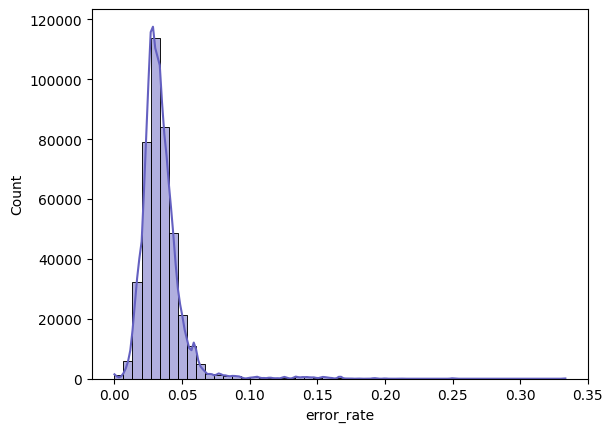

In [76]:
sns.histplot(data=df9, x='error_rate', bins=50, kde=True, color='#6460C1')
plt.show()

In [77]:
errate_perc_5 = df9['error_rate'].quantile(0.05)
errate_perc_33 = df9['error_rate'].quantile(0.33)
errate_perc_67 = df9['error_rate'].quantile(0.67)
errate_perc_75 = df9['error_rate'].quantile(0.75)
def errorate_categ(row):
  errate_catag = row['error_rate']
  if errate_catag <= errate_perc_33:
    return 'low'
  elif errate_catag > errate_perc_33 and errate_catag <= errate_perc_67:
    return 'medium'
  else:
    return 'high'

df9.loc[:, 'errate_categ'] = df9.apply(errorate_categ, axis=1)
df9.head()

,id,assignee_id,brand_id,forum_topic_id,organization_id,requester_id,submitter_id,group_id,custom_status_id,external_id,...,question,renewal,new,information,response_categ,discr_length,spelling_errors,error_categ,error_rate,errate_categ
0,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529,low
1,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529,low
2,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529,low
3,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529,low
4,6723,2.532106e+09,2129676.0,NaN,NaN,1381680743,259258347,20349457.0,4420939,NaN,...,0.0,0.0,0.0,0.0,Quick,Short,6.0,low,0.023529,low


In [78]:
resp_errate = df9.groupby('errate_categ')['resposne_days'].agg(['count', 'mean']).reset_index()
resp_errate

,errate_categ,count,mean
0,high,135818,43.921594
1,low,135983,48.887317
2,medium,139877,46.516189
